In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
import shap
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Reading the train dataset and dropping unnecessary columns
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)

# Loading the predicted labels for train set from the classifier
with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_pred_class = pickle.load(f)

# Splitting the train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, shuffle=False)

# Dropping the first 5 rows from validation dataset due to lagged features
X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

# Renaming columns
X_train.columns = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1).columns
X_val.columns = X_train.columns

# Feature selection

In [5]:
#Selecting the right predicted label for train and Validation
X_train['Class'] = y_pred_class[:len(X_train)]
X_val['Class'] = y_pred_class[len(X_train)+5:len(X_train)+len(X_val)+5]

In [6]:
# Defining XGBoost model semi-optimized hyperparams
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

dtrain = xgb.DMatrix(X_train[X_train['Class']==1].drop(columns=['Class']), y_train[X_train['Class']==1])
dval = xgb.DMatrix(X_val[X_val['Class']==1].drop(columns=['Class']), y_val[X_val['Class']==1])

# Training the XGBoost model on train and validation datasets
reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:16.57575	test-rmse:20.19251
[1]	train-rmse:15.97141	test-rmse:19.36562
[2]	train-rmse:15.40807	test-rmse:18.67045
[3]	train-rmse:14.84232	test-rmse:17.96016
[4]	train-rmse:14.30923	test-rmse:17.24785
[5]	train-rmse:13.83357	test-rmse:16.75660
[6]	train-rmse:13.36532	test-rmse:16.18284
[7]	train-rmse:12.91915	test-rmse:15.72520
[8]	train-rmse:12.50346	test-rmse:15.24902
[9]	train-rmse:12.08486	test-rmse:14.72920
[10]	train-rmse:11.69699	test-rmse:14.25216
[11]	train-rmse:11.34919	test-rmse:13.73282
[12]	train-rmse:11.02230	test-rmse:13.39550
[13]	train-rmse:10.70404	test-rmse:12.91003
[14]	train-rmse:10.39174	test-rmse:12.60847
[15]	train-rmse:10.09945	test-rmse:12.23679
[16]	train-rmse:9.80308	test-rmse:11.90478
[17]	train-rmse:9.52503	test-rmse:11.55763
[18]	train-rmse:9.25630	test-rmse:11.27970
[19]	train-rmse:9.01376	test-rmse:11.00708
[20]	train-rmse:8.80486	test-rmse:10.76484
[21]	train-rmse:8.57970	test-rmse:10.50373
[22]	train-rmse:8.37127	test-rmse:10.24974
[23]	

In [8]:
# Predicting the target values on train and validation datasets
y_pred_train = reg.predict(dtrain)
y_pred_val = reg.predict(dval)

# Getting feature importance using GAIN and WEIGHT methods
feat_importance = reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Getting top 10 SHAP values
explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train[X_train['Class']==1].drop(columns=['Class']))
shap_summary = pd.DataFrame(shap_values.values, columns=X_train[X_train['Class']==1].drop(columns=['Class']).columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

top_K_feat = list(set(top_10_gain+top_10_weight+top_10_shap))

# Saving the top K features
with open("./metadata/top_K_feat_anomalies_reg.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

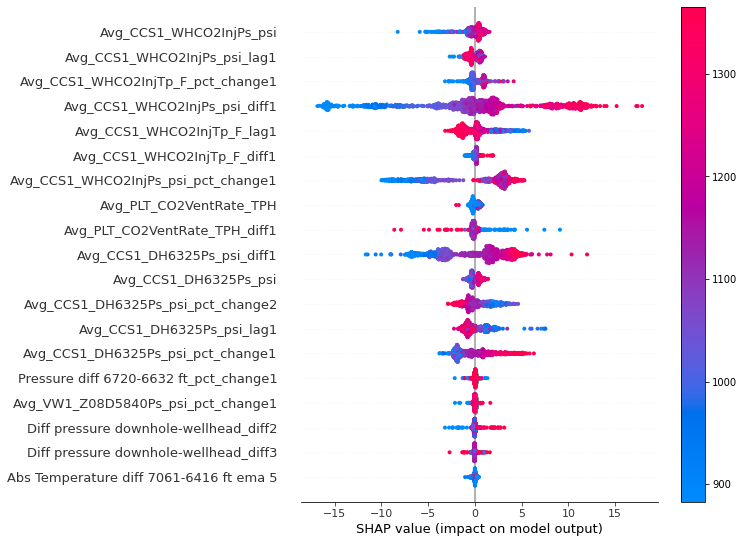

In [10]:
# Preparing the dataset for plotting SHAP values
full_x = train_set.drop(columns=['Target > 2','Abs Target','Date', 'Target'])
full_x['Class'] = y_pred_class
full_y = train_set['Target']
full_y = full_y[full_x['Class']==1]
full_x = full_x[full_x['Class']==1]

# Reordering columns for the SHAP plot
cols = [
    'Avg_CCS1_WHCO2InjPs_psi',
    'Avg_CCS1_WHCO2InjPs_psi_lag1',
    'Avg_CCS1_WHCO2InjTp_F_pct_change1',
    'Avg_CCS1_WHCO2InjPs_psi_diff1',
    'Avg_CCS1_WHCO2InjTp_F_lag1',
    'Avg_CCS1_WHCO2InjTp_F_diff1',
    'Avg_CCS1_WHCO2InjPs_psi_pct_change1',


    'Avg_PLT_CO2VentRate_TPH',
    'Avg_PLT_CO2VentRate_TPH_diff1',

    'Avg_CCS1_DH6325Ps_psi_diff1',
    'Avg_CCS1_DH6325Ps_psi',
    'Avg_CCS1_DH6325Ps_psi_pct_change2',
    'Avg_CCS1_DH6325Ps_psi_lag1',
    'Avg_CCS1_DH6325Ps_psi_pct_change1',

    'Pressure diff 6720-6632 ft_pct_change1',
    'Avg_VW1_Z08D5840Ps_psi_pct_change1',
    'Diff pressure downhole-wellhead_diff2',
    'Diff pressure downhole-wellhead_diff3',
    'Abs Temperature diff 7061-6416 ft ema 5',
]

full_x = full_x[cols]
dfull = xgb.DMatrix(full_x, full_y)

# Training the XGBoost model on the final dataset
reg = xgb.train(params,dfull,num_boost_round=int(reg.best_ntree_limit*1.09))

# Calculate shap values
explainer = shap.TreeExplainer(reg)
shap_values = explainer(full_x)

# Ordering the columns for the SHAP plot
order = full_x.columns
col2num = {col: i for i, col in enumerate(full_x)}
order = list(map(col2num.get, order))

# Plotting the SHAP values
shap.plots.beeswarm(shap_values, max_display=len(cols), show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()

## Hyperparameter Tunning

In [10]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)

# Select only the top K features based on the GAIN, WEIGHT and SHAP methods
x_train = x_train[list(top_K_feat)]

# Split the dataset into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

# Remove the first 5 rows from the validation set due to lagged values
X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

In [11]:
# Add the predicted label for each instance in the train and validation sets
X_train['Class'] = y_pred_class[:len(X_train)]
X_val['Class'] = y_pred_class[len(X_train)+5:len(X_train)+len(X_val)+5]

In [12]:
3 # Create DMatrix objects for the train and validation sets
dtrain = xgb.DMatrix(X_train[X_train['Class']==1].drop(columns=['Class']), y_train[X_train['Class']==1])
dval = xgb.DMatrix(X_val[X_val['Class']==1].drop(columns=['Class']), y_val[X_val['Class']==1])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [13]:
# Extract the ground truth target values for the validation set
y_test2 = y_val[X_val['Class']==1]
y_test2.reset_index(drop=True,inplace=True)

# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

# Iterate over all hyperparameter combinations and train and evaluate the XGBoost model on the validation set
for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = reg.predict(dtrain)
    y_pred_val = reg.predict(dval)

    num_trees = reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val[X_val['Class']==1], y_pred_val))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_test2, y_pred_val, sample_weight=np.abs(y_test2)/sum(np.abs(y_test2)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 7.39
MAPE: 0.30%
RMSE: 6.95
MAPE: 0.28%
RMSE: 7.34
MAPE: 0.30%
RMSE: 7.09
MAPE: 0.29%
RMSE: 7.07
MAPE: 0.28%
RMSE: 7.32
MAPE: 0.31%
RMSE: 7.39
MAPE: 0.31%
RMSE: 7.33
MAPE: 0.30%
RMSE: 7.29
MAPE: 0.29%
RMSE: 7.26
MAPE: 0.30%
RMSE: 7.22
MAPE: 0.29%
RMSE: 7.28
MAPE: 0.30%
RMSE: 7.34
MAPE: 0.30%
RMSE: 7.27
MAPE: 0.30%
RMSE: 7.10
MAPE: 0.29%
RMSE: 7.31
MAPE: 0.30%
RMSE: 6.99
MAPE: 0.28%
RMSE: 7.16
MAPE: 0.30%
RMSE: 7.24
MAPE: 0.30%
RMSE: 7.15
MAPE: 0.30%
RMSE: 7.16
MAPE: 0.29%
RMSE: 7.41
MAPE: 0.31%
RMSE: 7.37
MAPE: 0.31%
RMSE: 7.30
MAPE: 0.30%
RMSE: 7.23
MAPE: 0.29%
RMSE: 7.21
MAPE: 0.29%
RMSE: 7.21
MAPE: 0.28%
RMSE: 7.24
MAPE: 0.30%
RMSE: 7.36
MAPE: 0.30%
RMSE: 7.20
MAPE: 0.29%
RMSE: 7.39
MAPE: 0.30%
RMSE: 7.12
MAPE: 0.28%


In [14]:
# Find the best hyperparameters based on the highest AUCPR
best_idx = np.argmin([x['RMSE'] for x in results])

# Get the best threshold, hyperparameters, and optimal number of trees
best_hyperparams = results[best_idx]['hyperparameters']
opt_num_trees = num_trees_list[best_idx]

print(results[best_idx])
print(f'Num of trees: {opt_num_trees}')

{'hyperparameters': {'alpha': 1, 'lambda': 1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'RMSE': 6.951451361602832, 'MAPE': 0.2812087502045298}
Num of trees: 116


## Testing results on final validation set

In [16]:
# Splitting the data into train and test sets
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train = x_train[list(top_K_feat) ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

# Removing first 5 rows of test set and corresponding labels due to lagged features
X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]

In [17]:
# Loading the predicted labels for validation set
with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_val_class = pickle.load(f)

In [18]:
# Assigning predicted labels for train and test sets
X_train['Class']=y_pred_class[:len(X_train)]
X_test['Class']=y_val_class[-len(X_test):]

# Creating DMatrix for training and validation
dtrain = xgb.DMatrix(X_train[X_train['Class']==1].drop(columns=['Class']), y_train[X_train['Class']==1])
dtrain = xgb.DMatrix(X_train[X_train['Class']==1].drop(columns=['Class']), y_train[X_train['Class']==1])
dval = xgb.DMatrix(X_test[X_test['Class']==1].drop(columns=['Class']), y_test[X_test['Class']==1])

# Training the final model on best hyperparameters and optimal number of trees
reg = xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

# Predicting on the validation set
preds_reg=reg.predict(dval)
rmse_class_1 = np.sqrt(mean_squared_error( y_test[X_test['Class']==1], preds_reg))
rmse_class_1

6.4895199597284625

In [33]:
# Calculating the mean absolute percentage error for class 1
MAPE_class_1=mean_absolute_percentage_error(y_test[X_test['Class']==1], preds_reg, sample_weight=np.abs(y_test[X_test['Class']==1])/sum(np.abs(y_test[X_test['Class']==1])))
MAPE_class_1

0.28712292959431274

In [ ]:
# Save model trained with 85% of the data
reg.save_model('./output/regressor_class1/positive_class_xgb_validation_regressor.json')

No handles with labels found to put in legend.


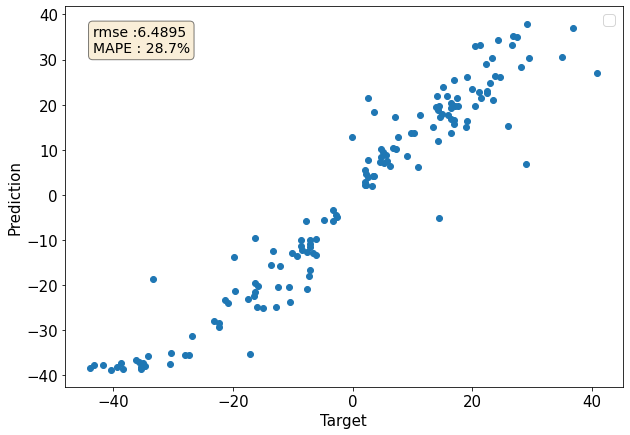

In [50]:
plt.scatter(X_test[X_test['Class']==1]['Target'], X_test[X_test['Class']==1]['Prediction'])
textstr = 'rmse :' + str(rmse_class_1.round(4)) +'\n' + 'MAPE : ' + str(100*MAPE_class_1.round(3)) +'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

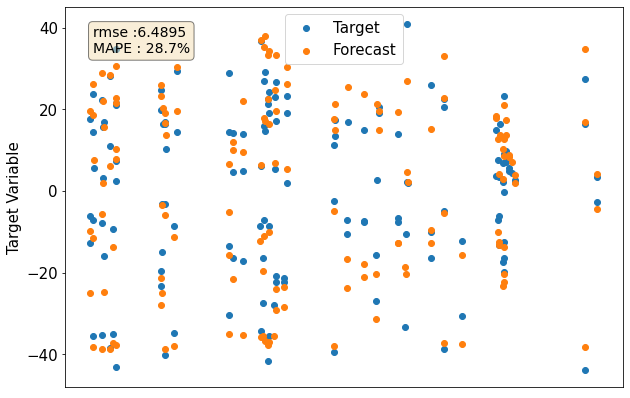

In [47]:
# plot the forecasted values against the real values
plt.scatter(X_test[X_test['Class']==1].index, X_test[X_test['Class']==1]['Target'], label='Target')
plt.scatter(X_test[X_test['Class']==1].index, X_test[X_test['Class']==1]['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse_class_1.round(4)) +'\n' + 'MAPE : ' + str(100*MAPE_class_1.round(3)) +'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.legend()
plt.show()

## Retrain final regressor with 100% of the train data

In [28]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
    
x_train = x_train[list(top_K_feat)]

x_train['Class'] = y_pred_class

dtrain = xgb.DMatrix(x_train[x_train['Class']==1].drop(columns=['Class']), y_train[x_train['Class']==1])
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

reg.save_model('./output/regressor_class1/positive_class_xgb_final_regressor.json')